In [125]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore') 

start = time.perf_counter()

In [126]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564 entries, 0 to 563
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            564 non-null    object 
 1   Player          564 non-null    object 
 2   MatchId         564 non-null    object 
 3   Map             564 non-null    object 
 4   Category        564 non-null    object 
 5   Playlist        564 non-null    object 
 6   Input           564 non-null    object 
 7   Queue           564 non-null    object 
 8   Csr             564 non-null    int64  
 9   Mmr             1 non-null      float64
 10  Outcome         564 non-null    object 
 11  Accuracy        564 non-null    float64
 12  DamageDone      564 non-null    int64  
 13  DamageTaken     564 non-null    int64  
 14  ShotsFired      564 non-null    int64  
 15  ShotsLanded     564 non-null    int64  
 16  ShotsMissed     564 non-null    int64  
 17  KD              564 non-null    flo

In [127]:
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df['DamageRatio'] = df['DamageDone'] / df['DamageTaken']
df['Damage/Kill'] = df['DamageDone'] / df['Kills']
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['Shots/10Min'] = (df['ShotsFired'] / df['LengthMinutes']) * 10
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']
df['ExcessKD'] = df['KD'] - (df['ExpectedKills'] / df['ExpectedDeaths'])

df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'Csr', 'ShotsFired', 
              'ShotsMissed', 'ShotsLanded', 'Betrayals', 'Suicides',
                'Perfects', 'Medals',
                'LengthSeconds'],axis=1)
dfR = df[df['Playlist'] == 'Ranked Arena']
dfRR = dfR[dfR['Date']> '2023-01-01']
dfRR = dfRR[dfRR['Outcome'] != 'Draw']
dfRR = dfRR[dfRR['Outcome'] != 'Left']
dfRR['Outcome'] = dfRR['Outcome'].map({'Win': 1, 'Loss': 0})
dfRR = dfRR.drop(['Date', 'Category', 'Playlist'], axis=1)
dfRR = dfRR.dropna()
dfRR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353 entries, 140 to 563
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Map             353 non-null    object 
 1   Outcome         353 non-null    int64  
 2   Accuracy        353 non-null    float64
 3   DamageDone      353 non-null    int64  
 4   DamageTaken     353 non-null    int64  
 5   KD              353 non-null    float64
 6   KDA             353 non-null    float64
 7   Kills           353 non-null    int64  
 8   Deaths          353 non-null    int64  
 9   Assists         353 non-null    int64  
 10  ExpectedKills   353 non-null    float64
 11  ExpectedDeaths  353 non-null    float64
 12  Score           353 non-null    int64  
 13  LengthMinutes   353 non-null    float64
 14  DamageRatio     353 non-null    float64
 15  Damage/Kill     353 non-null    float64
 16  Kills/10Min     353 non-null    float64
 17  Deaths/10Min    353 non-null    f

In [128]:
def cnt(df, col):
    count = df[col].count()
    return count
def sm(df, col):
    sum = df[col].sum()
    return sum
def avg(df, col, val=None):
    avg = round(sm(df, col) / cnt(df, col),val)
    return avg


In [129]:
corr_mtrx = dfRR.corr().abs()
print(corr_mtrx['Outcome'].sort_values(ascending=False))

Outcome           1.000000
Deaths/10Min      0.456834
DmgT/10Min        0.366563
Deaths            0.335071
KD                0.318696
ExcessDeaths      0.273696
DamageRatio       0.260062
KDA               0.251354
DamageTaken       0.251141
ExpectedDeaths    0.224620
ExcessKD          0.218125
Assists/10Min     0.204781
LengthMinutes     0.143719
Damage/Kill       0.142874
DamageDone        0.118780
Accuracy          0.089642
Kills/10Min       0.082355
Kills             0.060108
ExcessKills       0.057281
Assists           0.053662
ExpectedKills     0.036404
Score             0.014686
Dmg/10Min         0.012212
Shots/10Min       0.003077
Name: Outcome, dtype: float64


In [130]:
# dfRR.hist(bins=15, figsize=(16, 12))
# plt.tight_layout()
# plt.show()

In [131]:
dfRR.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Outcome,353.0,0.532578,0.499646,0.000000,0.000000,1.000000,1.000000,1.000000
Accuracy,353.0,52.064533,5.240944,36.800000,48.700000,52.330000,54.830000,80.560000
DamageDone,353.0,5111.776204,1837.392824,667.000000,3777.000000,4760.000000,6408.000000,12673.000000
DamageTaken,353.0,4401.181303,1558.567123,875.000000,3369.000000,4126.000000,5337.000000,9962.000000
KD,353.0,1.258442,0.680506,0.310000,0.860000,1.130000,1.440000,6.000000
KDA,353.0,4.454164,5.605155,-9.660000,0.660000,4.330000,7.660000,31.000000
Kills,353.0,14.498584,6.501802,1.000000,10.000000,14.000000,18.000000,40.000000
Deaths,353.0,12.759207,5.154029,1.000000,9.000000,12.000000,16.000000,30.000000
Assists,353.0,8.150142,4.108280,1.000000,5.000000,8.000000,10.000000,27.000000
ExpectedKills,353.0,14.203966,4.427225,3.000000,11.000000,13.000000,17.000000,28.000000


In [132]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [133]:
# Define features (X) and target variable (y)
X = dfRR.drop('Outcome', axis=1) 
X = round(X,20)
y = dfRR['Outcome'] 

print(f'X Shape: {X.shape}')
print(f'Y Shape: {y.shape}')

X Shape: (353, 24)
Y Shape: (353,)


In [134]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=2)
print(f'X Train Shape: {X_train.shape}')
print(f'X Test Shape: {X_test.shape}')

X Train Shape: (300, 24)
X Test Shape: (53, 24)


In [135]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['KD', 'KDA', 'Kills', 'Deaths', 'Assists', 'DamageDone', 'DamageTaken', 'DamageRatio', 
                                   'Damage/Kill', 'Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'Dmg/10Min', 'DmgT/10Min',
                                   'ExcessKills', 'ExcessDeaths', 'ExcessKD', 'ExpectedKills', 'ExpectedDeaths', 'Score', 'Shots/10Min']),
        ('cat', OneHotEncoder(), ['Map'])
    ])

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data
X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)

In [136]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

MSE_Histmean = mean_squared_error(y_test,np.full(y_test.shape,np.mean(y_train)))

def ResultsOut(model):
  y_pred = model.predict(X_test_preprocessed)
  # Calculate regression metrics
  acc = model.score(X_test_preprocessed, y_test)
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = mean_squared_error(y_test, y_pred, squared=False)
  r2 = r2_score(y_test, y_pred)
  oosr2 = 1-mean_squared_error(y_test,y_pred)/MSE_Histmean
  # Print the metrics with newline characters
  print("Acc: {:.3f}".format(acc))
  print("MAE: {:.2f}".format(mae))
  print("MSE: {:.2f}".format(mse))
  print("RMSE: {:.2f}".format(rmse))
  print("R^2 Score: {:.2f}".format(r2))
  print("OOS R^2 Score: {:.2f}".format(oosr2))
  return ''

def paramResults(mod):
    results_df = pd.DataFrame({'param': mod.cv_results_["params"], 'Accuracy': mod.cv_results_["mean_test_score"]})

    # Splitting the 'param' column into separate columns
    params_df = pd.DataFrame(results_df['param'].to_list())
    params_df.columns = [f"{col}_param" for col in params_df.columns]

    # Concatenating the new columns with the 'Accuracy' column
    results_df = pd.concat([params_df, results_df['Accuracy']], axis=1)

    # Displaying the updated DataFrame
    print(results_df)
    return ''

def featImport(mod):
    feat_importances = pd.DataFrame(mod.best_estimator_.feature_importances_[:20], index=X_train.columns, columns=["Importance"])
    feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
    feat_importances.plot(kind='bar', figsize=(8,6))
    plt.show()

## Logistic Regression

In [137]:
# Unregularized Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression(penalty=None)
logreg.fit(X_train_preprocessed, y_train)

print(f'Unregularized Logistic Regression Accuracy: {logreg.score(X_test_preprocessed, y_test)}')
print(ResultsOut(logreg))

Unregularized Logistic Regression Accuracy: 0.8301886792452831
Acc: 0.830
MAE: 0.17
MSE: 0.17
RMSE: 0.41
R^2 Score: 0.32
OOS R^2 Score: 0.32



## Ridge

In [138]:
# Ridge
# Need to find best params for param grid

C_grid = [10**-3,10**-2,10**-1,10**0,10**1,10**2]

param_grid={'C':C_grid}
ridge_cv = GridSearchCV(LogisticRegression(penalty='l2',solver='saga'),
                                          param_grid=param_grid,cv=5)
ridge_cv.fit(X_train_preprocessed,y_train)

print(ridge_cv.best_estimator_)
print(f'Ridge Accuracy: {ridge_cv.score(X_test_preprocessed, y_test)}')
ridge_cv.cv_results_
paramResults(ridge_cv)

LogisticRegression(C=10, solver='saga')
Ridge Accuracy: 0.9056603773584906
   C_param  Accuracy
0    0.001  0.646667
1    0.010  0.693333
2    0.100  0.740000
3    1.000  0.773333
4   10.000  0.780000
5  100.000  0.776667


''

In [139]:
ResultsOut(ridge_cv)

Acc: 0.906
MAE: 0.09
MSE: 0.09
RMSE: 0.31
R^2 Score: 0.62
OOS R^2 Score: 0.62


''

## Lasso

In [140]:
# Lasso

param_grid={'C':C_grid}
lasso_cv = GridSearchCV(LogisticRegression(penalty='l1',solver='saga'),
                                          param_grid=param_grid,cv=5)
lasso_cv.fit(X_train_preprocessed,y_train)

print(lasso_cv.best_estimator_)
print(f'Lasso Accuracy: {lasso_cv.score(X_test_preprocessed, y_test)}')
lasso_cv.cv_results_
paramResults(lasso_cv)


LogisticRegression(C=100, penalty='l1', solver='saga')
Lasso Accuracy: 0.9056603773584906
   C_param  Accuracy
0    0.001  0.536667
1    0.010  0.536667
2    0.100  0.696667
3    1.000  0.770000
4   10.000  0.776667
5  100.000  0.780000


''

In [141]:
ResultsOut(lasso_cv)

Acc: 0.906
MAE: 0.09
MSE: 0.09
RMSE: 0.31
R^2 Score: 0.62
OOS R^2 Score: 0.62


''

## ElasticNet

In [142]:
# ElasticNet

param_grid2={'C':C_grid,'l1_ratio':[.25, .5, .75]}

elastic_cv = GridSearchCV(LogisticRegression(penalty='elasticnet',solver='saga'),
                                            param_grid=param_grid2,cv=5)
elastic_cv.fit(X_train_preprocessed,y_train)

print(elastic_cv.best_estimator_)
print(f'ElasticNet Accuracy: {elastic_cv.score(X_test_preprocessed, y_test)}')
elastic_cv.cv_results_
paramResults(elastic_cv)

LogisticRegression(C=10, l1_ratio=0.25, penalty='elasticnet', solver='saga')
ElasticNet Accuracy: 0.9056603773584906
    C_param  l1_ratio_param  Accuracy
0     0.001            0.25  0.536667
1     0.001            0.50  0.536667
2     0.001            0.75  0.536667
3     0.010            0.25  0.686667
4     0.010            0.50  0.546667
5     0.010            0.75  0.536667
6     0.100            0.25  0.730000
7     0.100            0.50  0.716667
8     0.100            0.75  0.700000
9     1.000            0.25  0.773333
10    1.000            0.50  0.770000
11    1.000            0.75  0.766667
12   10.000            0.25  0.780000
13   10.000            0.50  0.780000
14   10.000            0.75  0.776667
15  100.000            0.25  0.780000
16  100.000            0.50  0.780000
17  100.000            0.75  0.780000


''

In [143]:
ResultsOut(elastic_cv)

Acc: 0.906
MAE: 0.09
MSE: 0.09
RMSE: 0.31
R^2 Score: 0.62
OOS R^2 Score: 0.62


''

## K-Nearest Neighbours

In [144]:
# K-Nearest Neighbours
from sklearn.neighbors import KNeighborsClassifier

k_values = list(range(1,50,3))
param_grid = {'n_neighbors': k_values}

knn_cv = GridSearchCV(KNeighborsClassifier(),param_grid,cv=5,n_jobs=-1)
knn_cv.fit(X_train_preprocessed,y_train)

print(knn_cv.best_estimator_)
print(f'K-Nearest Neighbors Accuracy: {knn_cv.score(X_test_preprocessed, y_test)}')
knn_cv.cv_results_
paramResults(knn_cv)

KNeighborsClassifier(n_neighbors=37)
K-Nearest Neighbors Accuracy: 0.6981132075471698
    n_neighbors_param  Accuracy
0                   1  0.676667
1                   4  0.666667
2                   7  0.696667
3                  10  0.673333
4                  13  0.700000
5                  16  0.693333
6                  19  0.693333
7                  22  0.683333
8                  25  0.703333
9                  28  0.693333
10                 31  0.686667
11                 34  0.700000
12                 37  0.706667
13                 40  0.703333
14                 43  0.696667
15                 46  0.700000
16                 49  0.690000


''

In [145]:
ResultsOut(knn_cv)

Acc: 0.698
MAE: 0.30
MSE: 0.30
RMSE: 0.55
R^2 Score: -0.21
OOS R^2 Score: -0.20


''

## Random Forest

In [146]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {'n_estimators': [100,300,500],'max_depth': [10, 15, 20]}
rf_cv = GridSearchCV(estimator=RandomForestClassifier(random_state=69,max_features='sqrt'),
                                                     cv=5, param_grid=param_grid_rf,n_jobs=-1)
rf_cv.fit(X_train_preprocessed, y_train)

print(rf_cv.best_estimator_)
print(f'Random Forest Accuracy: {rf_cv.score(X_test_preprocessed, y_test)}')
rf_cv.cv_results_
paramResults(rf_cv)

RandomForestClassifier(max_depth=10, n_estimators=300, random_state=69)
Random Forest Accuracy: 0.6792452830188679
   max_depth_param  n_estimators_param  Accuracy
0               10                 100  0.696667
1               10                 300  0.703333
2               10                 500  0.703333
3               15                 100  0.686667
4               15                 300  0.686667
5               15                 500  0.696667
6               20                 100  0.686667
7               20                 300  0.683333
8               20                 500  0.693333


''

In [147]:
ResultsOut(rf_cv)

Acc: 0.679
MAE: 0.32
MSE: 0.32
RMSE: 0.57
R^2 Score: -0.28
OOS R^2 Score: -0.28


''

<AxesSubplot: >

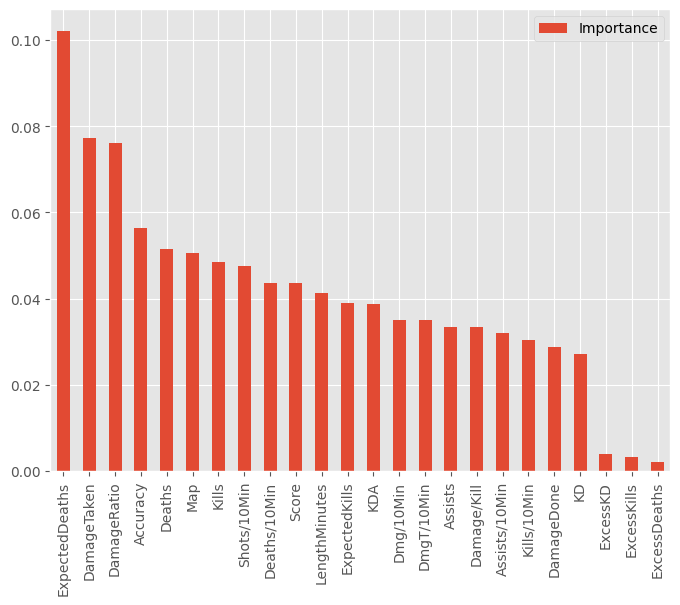

In [148]:
feat_importances = pd.DataFrame(rf_cv.best_estimator_.feature_importances_[:24], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

## Gradient Boosted Trees

In [149]:
# Gradient Boosted Trees
from sklearn.ensemble import GradientBoostingClassifier

param_grid_gbrt = {'n_estimators': [100,300,500],'learning_rate': [0.01,0.1],'max_depth': [2,4,6], 'subsample': [0.5,1]}
GBRT = GridSearchCV(estimator=GradientBoostingClassifier(random_state=69),
                    cv=5, param_grid=param_grid_gbrt,n_jobs=-1)
GBRT.fit(X_train_preprocessed, y_train)

print(GBRT.best_estimator_)
print(f'Gradient Boosed Trees Accuracy: {GBRT.score(X_test_preprocessed, y_test)}')
GBRT.cv_results_
paramResults(GBRT)

GradientBoostingClassifier(max_depth=4, n_estimators=300, random_state=69,
                           subsample=1)
Gradient Boosed Trees Accuracy: 0.6792452830188679
    learning_rate_param  max_depth_param  n_estimators_param  subsample_param  \
0                  0.01                2                 100              0.5   
1                  0.01                2                 100              1.0   
2                  0.01                2                 300              0.5   
3                  0.01                2                 300              1.0   
4                  0.01                2                 500              0.5   
5                  0.01                2                 500              1.0   
6                  0.01                4                 100              0.5   
7                  0.01                4                 100              1.0   
8                  0.01                4                 300              0.5   
9                  0.01 

''

In [150]:
ResultsOut(GBRT)

Acc: 0.679
MAE: 0.32
MSE: 0.32
RMSE: 0.57
R^2 Score: -0.28
OOS R^2 Score: -0.28


''

<AxesSubplot: >

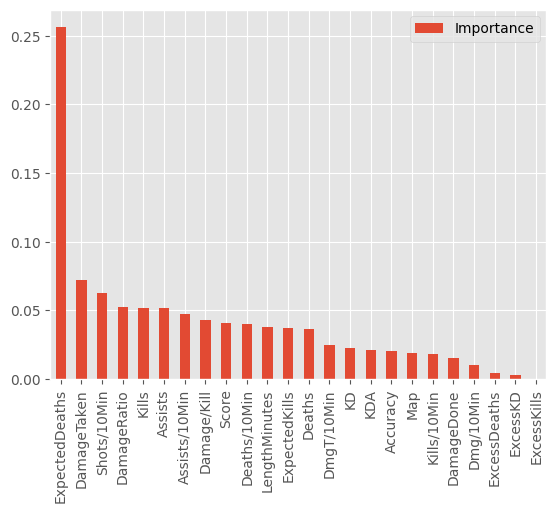

In [151]:
feat_importances = pd.DataFrame(GBRT.best_estimator_.feature_importances_[:24], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar')

## XGBoost

In [152]:
from xgboost import XGBClassifier

param_grid_xgb = {'n_estimators': [400,450,475,500],'learning_rate': [0.001,0.01,0.1,0.25],'max_depth': [1,2,3,4,5]}
XGB = GridSearchCV(estimator=XGBClassifier(random_state=69), cv=5, param_grid=param_grid_xgb,n_jobs=-1)
XGB.fit(X_train_preprocessed, y_train)

print(XGB.best_estimator_)
print(f'XGBoost Accuracy: {XGB.score(X_test_preprocessed, y_test)}')
paramResults(XGB)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=450, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=69, ...)
XGBoost Accuracy: 0.7169811320754716
    learning_rate_param  max_depth_param  n_estimators_param  Accuracy
0                 0.001                1                 400  0.693333
1                 0.001                1                 450  0.693333
2  

''

In [153]:
ResultsOut(XGB)

Acc: 0.717
MAE: 0.28
MSE: 0.28
RMSE: 0.53
R^2 Score: -0.13
OOS R^2 Score: -0.13


''

<AxesSubplot: >

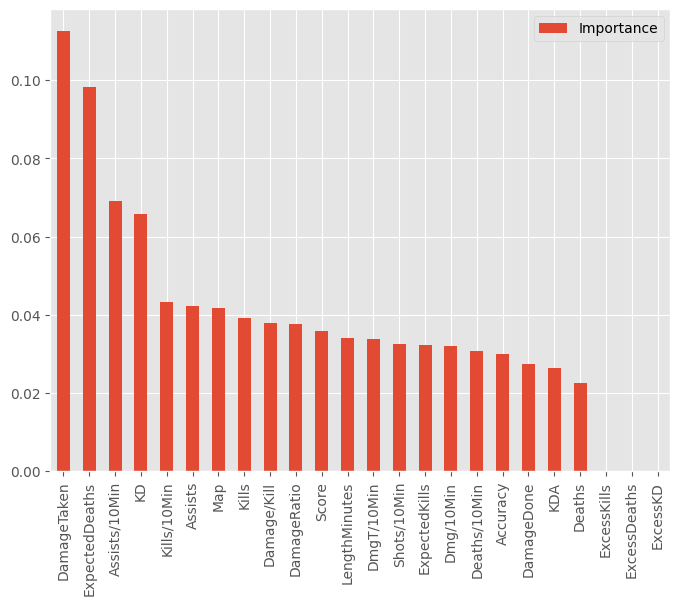

In [154]:
feat_importances = pd.DataFrame(XGB.best_estimator_.feature_importances_[:24], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

Runtime: 26.52s


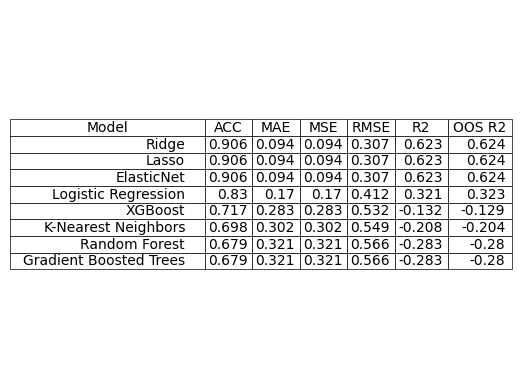

In [155]:
modelss = [logreg,ridge_cv,lasso_cv,elastic_cv,knn_cv,rf_cv,GBRT,XGB]
model_namess = ['Logistic Regression', 'Ridge', 'Lasso', 'ElasticNet',
              'K-Nearest Neighbors', 'Random Forest', 'Gradient Boosted Trees', 'XGBoost']
def saveResults(models, model_names):
    # Initialize an empty dataframe to store the metrics
    metrics_df = pd.DataFrame(columns=['Model', 'ACC' ,'MAE', 'MSE', 'RMSE', 'R2', 'OOS R2'])
    
    # Loop through each model and calculate the metrics
    for i, model in enumerate(models):
        # Generate predictions on the test set
        y_pred = model.predict(X_test_preprocessed)
        
        # Calculate regression metrics
        acc = round(model.score(X_test_preprocessed, y_test),3)
        mae = round(mean_absolute_error(y_test, y_pred),3)
        mse = round(mean_squared_error(y_test, y_pred),3)
        rmse = round(mean_squared_error(y_test, y_pred, squared=False),3)
        r2 = round(r2_score(y_test, y_pred),3)
        oosr2 = round(1-mean_squared_error(y_test,y_pred)/MSE_Histmean,3)
        
        # Add metrics to the dataframe
        metrics_df.loc[i] = [model_names[i],acc, mae, mse, rmse, r2, oosr2]
    
    metrics_df = metrics_df.sort_values('ACC', ascending=False).reset_index(drop=True)

    fig, ax = plt.subplots()
    table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns,
                     cellLoc='right', loc='center')
    table.auto_set_font_size(True)
    table.auto_set_column_width(col=list(range(len(metrics_df.columns))))
    ax.axis('off')
    plt.savefig('ModelResults1209-4.png', dpi=300, bbox_inches='tight')
    
    return metrics_df

saveResults(modelss,model_namess)
print(f'Runtime: {round(time.perf_counter() - start,2)}s')